# **Promoter Classifier using AttentionDrivenLSTM (PuCADIL)**

Here we make a Markov model which given a sequence classifies the it as either having atleast one promoter site or has having no promoter site.

## README

To execute the below code, press the runall button and execute the cells sequentially. This script has, at the end support for sstoring and loading the model as well, and thus will make files and folders on its own with model names. 

The Hyperparameter optimization step section of the code tries to find the order of the markov model that gives the best scores for the validation dataset. This step generally takes long times (Approx 5 mins) to execute.

During Validation, we first use single test train split to validate, and thus get a single ROC and AUC, and then we perform K-Fold validation. We observe that the K-fold validation gives very close ROCs, and thus for the hyperparameter optimization, we only perform single test-train splits to optimize the order.

Necessary conditions for running the code are:
1. A folder named database that includes the negative.fa.gz and positive.fa.gz files must be kept in the same directory as the code.
2. Python version and dependencies needed are mentioned here:
    1. python == 3.10.14
    2. Biopython == 1.79
    3. matplotlib == 3.9.2
    4. numpy == 2.1.1
    5. tqdm == 4.66.4

The code also works if the versions aren't mentioned and are directly installed with "pip install biopython matplotlib numpy tqdm"

### Note:

While making the n-order markov model, we add a padding of n Xs as the start symbol to the sequence. These are then taken as the start n-mer and the rest of the calculations are carried out similar to a sliding window algorithm. The stop symbol as well is just an X symbol. The symbol for both start and stop can be the same as the transition probability from any n-mer to X can only be at the end, and transition probability from X to anything else can only be in the start, by design. 

## INPUTS
* NEG_PATH = path to negative.fa.gz file
* POS_PATH = path to positive.fa.gz file
* K = folds of validation
* ORDER = order of the markov model
* TO_OPTIMIZE_HYPERPARAMETERS = whether hyperparameter optimization is to be done (default to _False_)


In [62]:
# NEG_PATH = "CFG/Project/database/negative.fa.gz"
# POS_PATH = "CFG/Project/database/positive.fa.gz"
NEG_PATH = "./database/negative.fa.gz"
POS_PATH = "./database/positive.fa.gz"
K = 5
ORDER = 2
TO_OPTIMIZE_HYPERPARAMETERS = 0


## Importing the libraries

In [63]:
!pwd
!cd Project/
!pwd

/storage/madhu/deep/CFG/Project
/bin/bash: line 0: cd: Project/: No such file or directory
/storage/madhu/deep/CFG/Project


In [64]:
import time
start_time = time.time()
import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import gzip
from Bio.SeqIO import parse
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import os


In [65]:
if not os.path.exists('./database'):
    os.makedirs('./database')
if not os.path.exists('./results'):
    os.makedirs('./results')
if not os.path.exists('./models'):
    os.makedirs('./models')

print(os.path.exists(NEG_PATH))

True


## **Data Analysis and visualization**

## Importing the dataset

In [66]:
# Importing the data
with gzip.open(NEG_PATH, "rt") as handle:
    database_neg = []
    for record in parse(handle, "fasta"):
        # print(type(record))
        database_neg.append(record.seq)
print('Negative Database length = ', len(database_neg)) # 100000
print('Negative seq sample = ', database_neg[0])
# Data shows 100000 positive and negative samples

with gzip.open(POS_PATH, "rt") as handle:
    database_pos = []
    for record in parse(handle, "fasta"):
        # print(type(record))
        database_pos.append(record.seq)
print('Positive Database length = ',len(database_pos))  # 100000
print('Positive seq sample = ', database_pos[0])
# Data shows 100000 positive and negative samples


Negative Database length =  100000
Negative seq sample =  TAAATTAGGCCTTTATTATGTAGTGGGTATTTGTTTATTGGTAGCATATCAATCTATGAGGAGTTAGTGGCTCGTCAA
Positive Database length =  100000
Positive seq sample =  TAGTATATACTTTCGCTGAATTATCACGATCGTCGAGGTAAGGAAGGTAACTACATACGCTCGCATAGGGTAATGTATC


## Visualizing the sequences

Maximum length of the sequence in negative database =  108
Minimum length of the sequence in negative database =  54
Maximum length of the sequence in positive database =  106
Minimum length of the sequence in positive database =  54


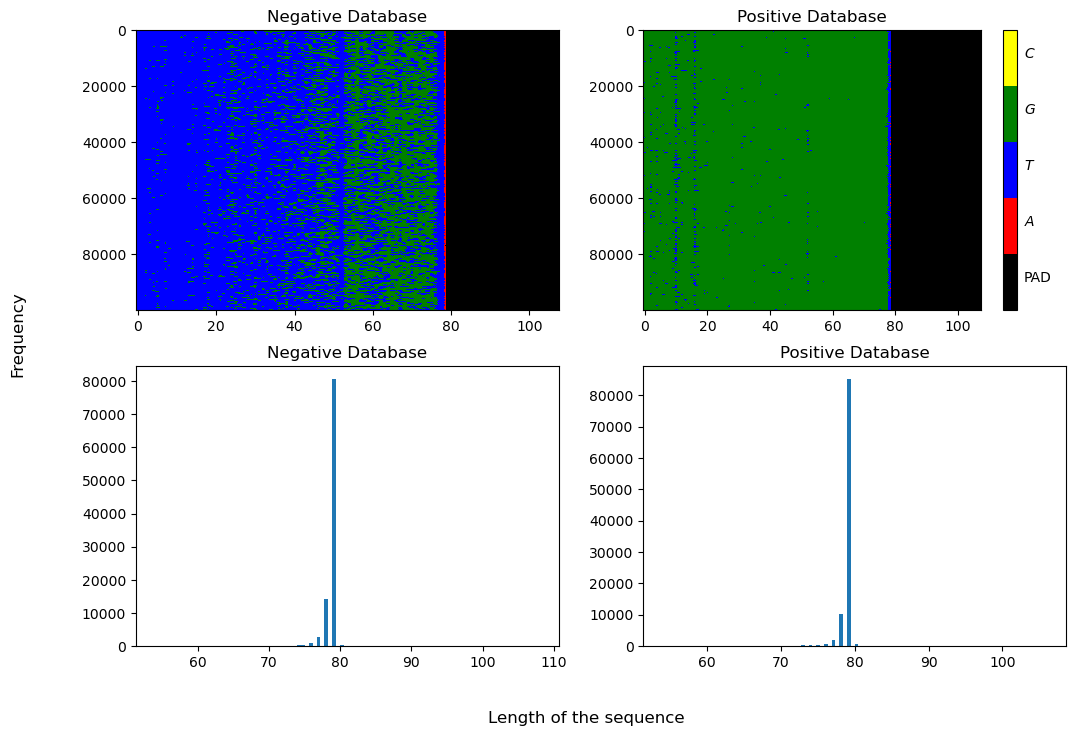

<Figure size 640x480 with 0 Axes>

In [67]:
# Plotting to see if any of the sequences have any patterns in their sequence without alignment
dictionary = ['A','T','G','C']
dict_for_cmap = ['PAD','A','T','G','C']
tokenized_neg = [[dict_for_cmap.index(i) for i in database_neg[j]] for j in range(len(database_neg))]
tokenized_pos = [[dict_for_cmap.index(i) for i in database_pos[j]] for j in range(len(database_pos))]

# Padding the sequences for visualization
lens_n = [len(j) for j in tokenized_neg]
max_n = max(lens_n)
min_n = min(lens_n)

lens_p = [len(j) for j in tokenized_pos]
max_p = max(lens_p)
min_p = min(lens_p)

print('Maximum length of the sequence in negative database = ', max_n)
print('Minimum length of the sequence in negative database = ', min_n)
tokenized_neg = [i + [0]*(max(max_n,max_p)-len(i)) for i in tokenized_neg]

print('Maximum length of the sequence in positive database = ', max_p)
print('Minimum length of the sequence in positive database = ', min_p)
tokenized_pos = [i + [0]*(max(max_n,max_p)-len(i)) for i in tokenized_pos]

cmap = mpl.colors.ListedColormap(['black','red','blue','green','yellow'])
# norm = mpl.colors.BoundaryNorm([0,1,2,3], cmap.N)
# Plotting the tokenized sequences
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(2,2,1)
ax.imshow(tokenized_neg, aspect='auto',cmap=cmap)
ax.set_title('Negative Database')
ax = plt.subplot(2,2,2)
plot = ax.imshow(tokenized_pos, aspect='auto',cmap=cmap)
cbar = fig.colorbar(plot)

cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['PAD','$A$','$T$','$G$','$C$']):
    cbar.ax.text(1.5, 2*(2 * j + 1) / 5.0, lab)
cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel('# of contacts', rotation=270)
# cbar.ax.set_yticklabels(dict_for_cmap)
ax.set_title('Positive Database')

ax = plt.subplot(2,2,3)
ax.hist(lens_n, bins=100)
ax.set_title('Negative Database')
ax = plt.subplot(2,2,4)
ax.hist(lens_p, bins=100)
ax.set_title('Positive Database')
fig.supxlabel('Length of the sequence')
fig.supylabel('Frequency')
plt.show()
plt.tight_layout()



## Visualizing the frequencies of residues

In [ ]:
# Visualizing the concensus sequence for + and -
def get_consensus(tokenized):
    concensus = np.zeros((5,max(max_n,max_p)))
    for ele in tokenized:
        for i in range(len(ele)):
            concensus[ele[i]][i]+=1
    concensus = concensus/len(tokenized)
    return concensus

consensus_neg = get_consensus(tokenized_neg)
consensus_pos = get_consensus(tokenized_pos)

# NOTE: Uncomment these the get the image in matrix form
# print(consensus_neg)
# print(consensus_pos)

fig=plt.figure(figsize=(12,8))
ax = plt.subplot(1,2,1)
ax.imshow(consensus_neg, aspect='auto')
ax.set_yticks([0,1,2,3,4],dict_for_cmap)
ax.set_title('Negative Database')
ax = plt.subplot(1,2,2)
plot = ax.imshow(consensus_pos, aspect='auto')
ax.set_yticks([0,1,2,3,4],dict_for_cmap)
ax.set_title('Positive Database')
cbar = fig.colorbar(plot)
fig.supxlabel('Length of the sequence')
# fig.supylabel('Frequency')
# cbar.ax.get_yaxis().set_ticks([])
# for j, lab in enumerate(['PAD','$A$','$T$','$G$','$C$']):
#     cbar.ax.text(1.5, 2*(2 * j + 1) / 5.0, lab)
# cbar.ax.get_yaxis().labelpad = 15
plt.tight_layout()


We can see that T is more in Negative database and G is more in Positive database. Indicating that there is a corelation with GC content

The padding is required for most sequences except one or two -> Wont be a problem in markov models anyways, but could be a potential problem for NN

# Prepping the data for model (encoding)

In [ ]:
# here we will make one hot encodings from the data, add a start and an end token (both as $) [end can have multiple $ tokens which is padding] to the model with encoding [0,0,0,0].

# first we remove the long sequence from the data

len_cutoff = 80


tokenized_neg = [[dict_for_cmap.index(i) for i in database_neg[j]] for j in range(len(database_neg))]
tokenized_pos = [[dict_for_cmap.index(i) for i in database_pos[j]] for j in range(len(database_pos))]

# mn = max([len(t) for t in tokenized_neg])
# mp = max([len(t) for t in tokenized_pos])

print("We will ignore : ",sum([len(t)>80 for t in tokenized_neg]),f" many sequences = {sum([len(t)>80 for t in tokenized_neg])*100/len(tokenized_neg)} percentage of the data ","from the negative database as they are above 80 bases long")
print("We will ignore : ",sum([len(t)>80 for t in tokenized_pos]),f" many sequences  = {sum([len(t)>80 for t in tokenized_pos])*100/len(tokenized_pos)} percentage of the data  from the positive database as they are above 80 bases long")


We will ignore :  138  many sequences = 0.138 percentage of the data  from the negative database as they are above 80 bases long
We will ignore :  131  many sequences  = 0.131 percentage of the data  from the positive database as they are above 80 bases long


In [ ]:
sample_I = np.eye(len(dictionary))
tokenized_neg = np.array([np.array([np.zeros(len(dictionary))]+[sample_I[dictionary.index(i)] for i in database_neg[j]]+[np.zeros(len(dictionary))]*(len_cutoff-len(database_neg[j])+1)) for j in range(len(database_neg)) if len(database_neg[j])<=len_cutoff])
tokenized_pos = np.array([np.array([np.zeros(len(dictionary))]+[sample_I[dictionary.index(i)] for i in database_pos[j]]+[np.zeros(len(dictionary))]*(len_cutoff-len(database_pos[j])+1)) for j in range(len(database_pos)) if len(database_pos[j])<=len_cutoff])
print(tokenized_neg.shape)
print(tokenized_pos.shape)

(99862, 82, 4)
(99869, 82, 4)


## **Test-Train split**

In [ ]:

train_split = 0.8 # 80% of the data is used for training
# Splitting the data into training and testing
train_neg = tokenized_neg[:int(len(tokenized_neg)*train_split)]
test_neg = tokenized_neg[int(len(tokenized_neg)*train_split):]

train_pos = tokenized_pos[:int(len(tokenized_pos)*train_split)]
test_pos = tokenized_pos[int(len(tokenized_pos)*train_split):]

train_data = np.concatenate((train_neg,train_pos),axis=0)
test_data = np.concatenate((test_neg,test_pos),axis=0)
train_target = np.array([0.]*len(train_neg)+[1.]*len(train_pos))
test_target = np.array([0.]*len(test_neg)+[1.]*len(test_pos))

# randomizing the train and test data
shuffling_train = np.random.choice(len(train_data),len(train_data))
shuffling_test = np.random.choice(len(test_data),len(test_data))

train_data = torch.tensor(train_data[shuffling_train]).to(float)
train_target = torch.tensor(train_target[shuffling_train].reshape(-1,1)).to(float)

test_data = torch.tensor(test_data[shuffling_test]).to(float)
test_target = torch.tensor(test_target[shuffling_test].reshape(-1,1)).to(float)

print("Shape of train_data = ",train_data.shape)
print("Shape of train_target = ",train_target.shape)

print("Shape of test_data = ",test_data.shape)
print("Shape of test_target = ",test_target.shape)


Shape of train_data =  torch.Size([159784, 82, 4])
Shape of train_target =  torch.Size([159784, 1])
Shape of test_data =  torch.Size([39947, 82, 4])
Shape of test_target =  torch.Size([39947, 1])


## **Making the model**

In [ ]:
# Making the Model


class LSTMModel(nn.Module):
    def __init__(self,input_dims=4,hidden_dims=1,num_output_neurons=1,num_layers = 1,bidirectionality = False):
        super().__init__()
        self.inp = input_dims
        self.num_layers = num_layers
        self.hid = hidden_dims
        self.out = num_output_neurons
        self.bidir = bidirectionality
        self.recording = True
        self.record = {}
        D = 4 if self.bidir else 1
        self.RNN = nn.LSTM(self.inp,self.hid,self.num_layers,batch_first = True,bidirectional=self.bidir)
        # self.DNN1 = nn.Linear(D*self.hid,D*self.hid)
        # self.bn1 = nn.BatchNorm1d(D*self.hid)
        # self.DNN2 = nn.Linear(D*self.hid,D*self.hid)
        # self.bn2 = nn.BatchNorm1d(D*self.hid)
        # self.DNN3 = nn.Linear(D*self.hid,D*self.hid)
        # self.bn3 = nn.BatchNorm1d(D*self.hid)
        self.DNN4 = nn.Linear(D*self.hid,self.out)
    def start_recording(self):
        self.recording = True
    def stop_recording(self):
        self.recording = False
    def forward(self,x):
        '''
        Note: x should be ending with a $ sign, the encoding of which is [0,0,0,0]. This will be passed to the DNN
        if is bidirectional, then should start and end with $ signs
        '''

        out,_ = self.RNN(x)
        # print(out,type(out))
        if not self.bidir:
            last_token = out[:,-1,:]
            # print(last_token.shape)
            # out = F.dropout(F.relu(self.bn1(self.DNN1(last_token))),p=0.1)
            # out = F.dropout(F.relu(self.bn2(self.DNN2(out))),p=0.1)
            # out = F.dropout(F.relu(self.bn3(self.DNN3(out))),p=0.1)
            # out = (self.DNN4(out))
            out = (self.DNN4(last_token))
            # print(out.shape)
            if self.recording:
                self.record = {'last_token':last_token,'out1':out}
        else:
            # NOTE: This does not function correctly DO NOT USE
            last_token = out[:,-1,:]
            first_token = out[:,0,:]
            # out = F.dropout(F.relu(self.bn1(self.DNN1(torch.concatenate((first_token,last_token),dims=-1)))),p=0.1)
            # out = F.dropout(F.relu(self.bn2(self.DNN2(out))),p=0.1)
            # out = F.dropout(F.relu(self.bn3(self.DNN3(out))),p=0.1)
            out = (self.DNN4(out))
        out = F.sigmoid(out)
        # print(out.shape)
        if self.recording:
            self.record['out'] = out

        return torch.reshape(out,(-1,self.out))

model = LSTMModel(input_dims=4,hidden_dims=64,num_output_neurons=1,num_layers = 1,bidirectionality = False)
print(model)


LSTMModel(
  (RNN): LSTM(4, 64, batch_first=True)
  (DNN4): Linear(in_features=64, out_features=1, bias=True)
)


# Training the model

In [ ]:
learning_rate = 0.02
epochs = 15
batch_size = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
model.to(float)

def get_acc(testingX,testingY):
  accuracy = 0
  correct = 0
  total = 0
  mse= 0
  with torch.no_grad():
    model.eval()
    inp = testingX.to(device)
    y_pred_eval = model(inp)
    y_true_eval =(testingY).to(device)
    # print(y_pred_eval.shape)
    # print(y_true_eval.shape)
    # y_pred_eval = torch.reshape(y_pred_eval,(-1,y_pred_eval.shape[-2],y_pred_eval.shape[-1]))
    y_true_eval = torch.reshape(y_true_eval,(y_pred_eval.shape[-2],y_pred_eval.shape[-1]))
    eval_loss = criterion(y_pred_eval,y_true_eval).cpu().item()
    # print('Probability for it to be an odd number = ',y_pred.item())
    # print('The actual number = ',y_true,'\n')
    diff_eval = y_pred_eval - y_true_eval
    correct = torch.sum((diff_eval>-0.5) & (diff_eval <0.5)).cpu().detach().item()
    total = len(diff_eval)
    # correct = 
    # for y_pred_sing,y_true_sing in zip(y_pred_eval,y_true_eval):
    #     if y_pred_sing.cpu().detach().item()>0.5 and y_true_sing.cpu().detach().item()>0.5:
    #       correct+=1
    #     elif y_pred_sing.cpu().detach().item()<0.5 and y_true_sing.cpu().detach().item()<0.5:
    #        correct+=1
    #     total+=1
    # print('Accuracy = ',correct/total)
    return eval_loss,correct/total

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


In [ ]:

losses = []
testing_loss = []
accuracies = []
testing_accuracies = []
its=[]
count=0
for e in tqdm(range(epochs)):
    total_minibatches = len(train_data)//batch_size
    for i in range(total_minibatches):
        model.train()
        if i!=total_minibatches-1:
            input_data = train_data[i*batch_size:(i+1)*batch_size].to(device)
            y_true = train_target[i*batch_size:(i+1)*batch_size].to(device)
        else:
            input_data = train_data[i*batch_size:].to(device)
            y_true = train_target[i*batch_size:].to(device)
        y_pred = model(input_data)
        # print(y_pred,y_true)
        loss = criterion(y_pred,y_true)
        losses.append(loss.item())
        its.append(count)
        count+=1
        loss.backward()
        tel,tea = get_acc(test_data,test_target)
        tal,taa = get_acc(input_data,y_true)
        testing_loss.append(tel)
        accuracies.append(taa)
        testing_accuracies.append(tea)
        optimizer.step()
        optimizer.zero_grad()
        

100%|██████████| 2/2 [00:30<00:00, 15.38s/it]


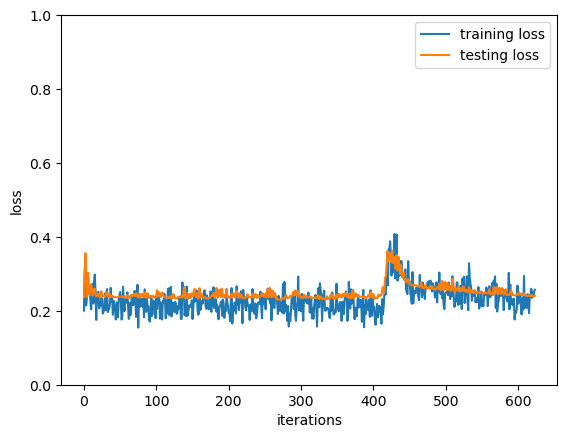

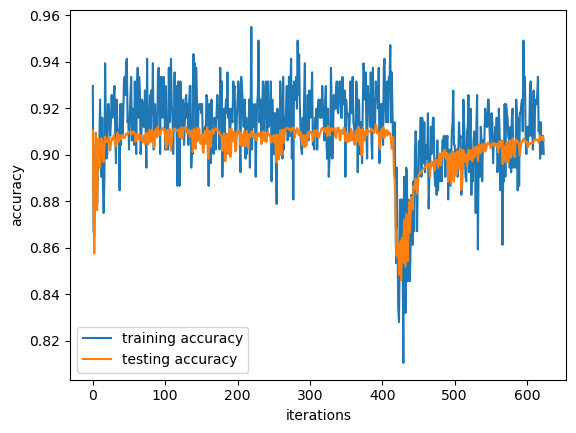

In [ ]:
plt.plot(its,losses,label='training loss')
plt.plot(its,testing_loss,label='testing loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.ylim(0,1)
plt.legend()
plt.show()
plt.close()

plt.plot(its,accuracies,label='training accuracy')
plt.plot(its,testing_accuracies,label='testing accuracy')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Checking on a testing data to see how the model performs

In [ ]:
l,a = get_acc(test_data,test_target)
print('The final testing loss is %.2f and the final testing accuracy is %.2f' % (l,a))
# torch.save(model,f'./models/model_LSTMModel_{a}.pt')

The final testing loss is 0.24 and the final testing accuracy is 0.91


In [ ]:
# # model = LSTMModel()
# model = (torch.load(f'./models/model_LSTMModel_{a}.pt'))
# print(model)

/tmp/ipykernel_2718334/371537121.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = (torch.load(f'./models/model_LSTMModel_{a}.pt'))


LSTMModel(
  (RNN): LSTM(4, 64, batch_first=True)
  (DNN4): Linear(in_features=64, out_features=1, bias=True)
)


last_token


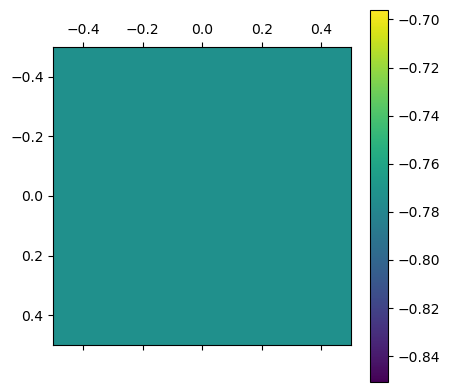

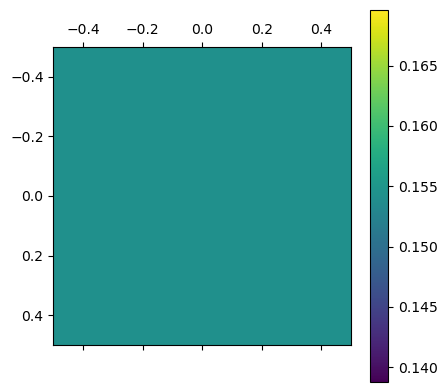

out1


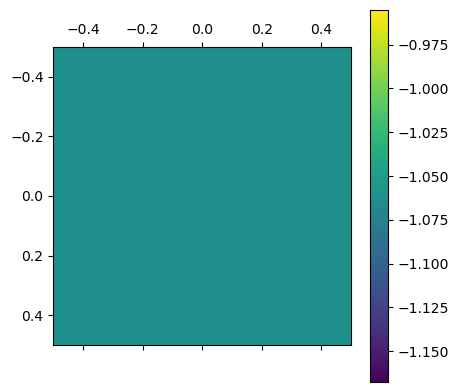

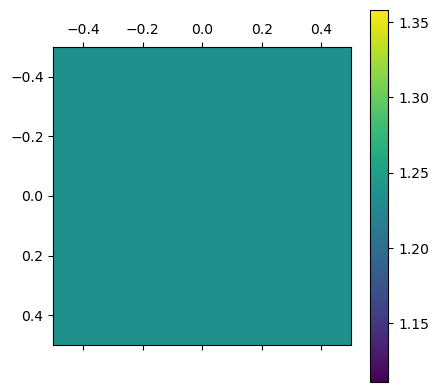

out


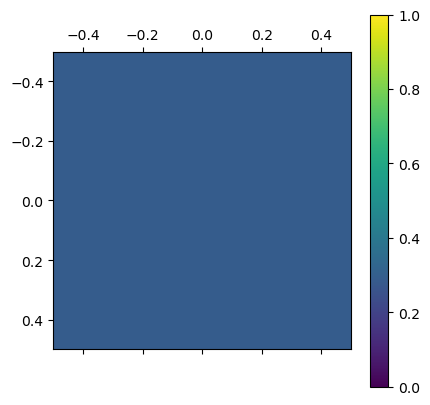

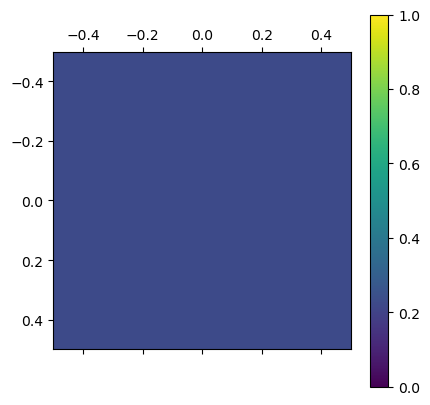

last_token


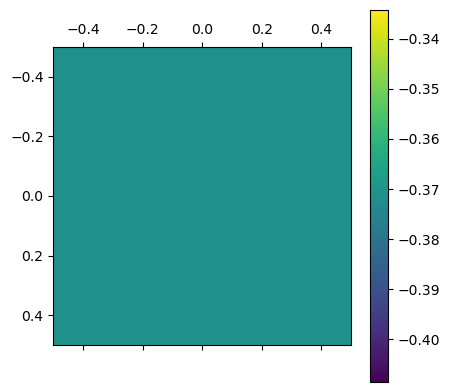

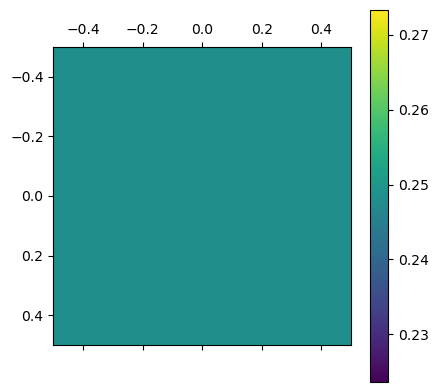

out1


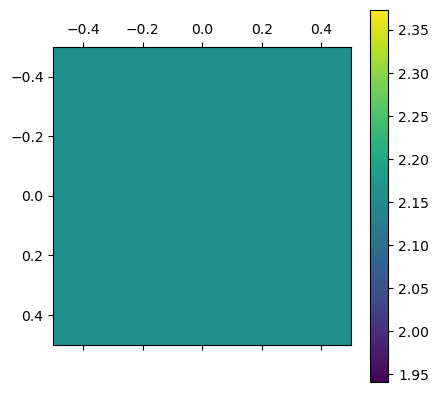

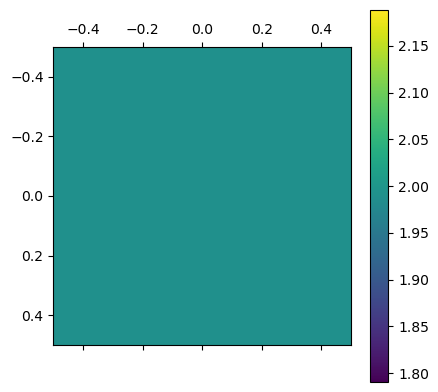

out


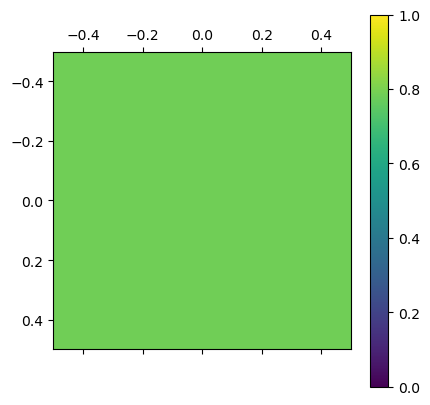

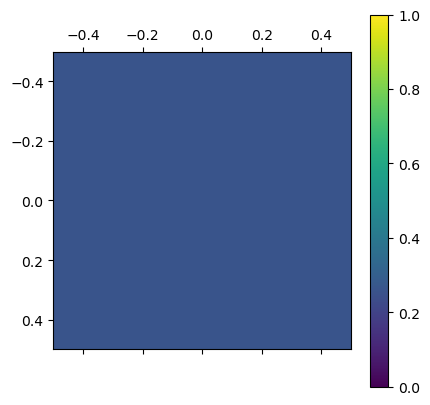

In [ ]:

model.start_recording()
get_acc(torch.tensor(test_neg,dtype=float),torch.tensor([0.]*len(test_neg),dtype=float))
for k in model.record:
    print(k)
    plt.matshow(np.average(model.record[k].cpu().detach().numpy(),axis=0,keepdims=True),cmap = 'viridis')
    plt.colorbar()
    if k=='out':
        plt.clim(0,1)
    plt.show()
    plt.close()
    plt.matshow(np.std(model.record[k].cpu().detach().numpy(),axis=0,keepdims=True),cmap = 'viridis')
    plt.colorbar()
    if k=='out':
        plt.clim(0,1)
    plt.show()
    plt.close()

get_acc(torch.tensor(test_pos,dtype=float),torch.tensor([1.]*len(test_pos),dtype=float))
for k in model.record:
    print(k)
    plt.matshow(np.average(model.record[k].cpu().detach().numpy(),axis=0,keepdims=True),cmap = 'viridis')
    plt.colorbar()
    if k=='out':
        plt.clim(0,1)
    plt.show()
    plt.close()
    plt.matshow(np.std(model.record[k].cpu().detach().numpy(),axis=0,keepdims=True),cmap = 'viridis')
    plt.colorbar()
    if k=='out':
        plt.clim(0,1)
    plt.show()
    plt.close()
layer_no = 0


LSTM(4, 1, batch_first=True)


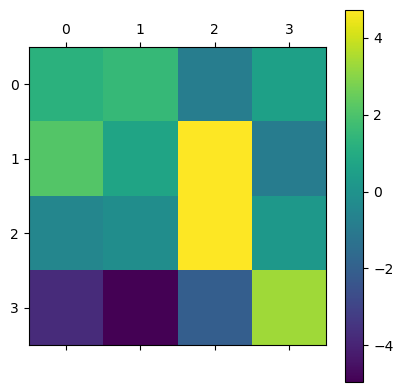

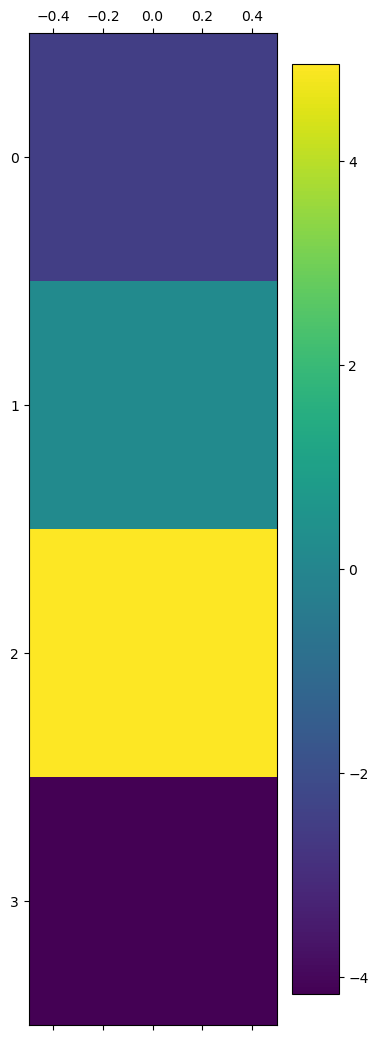

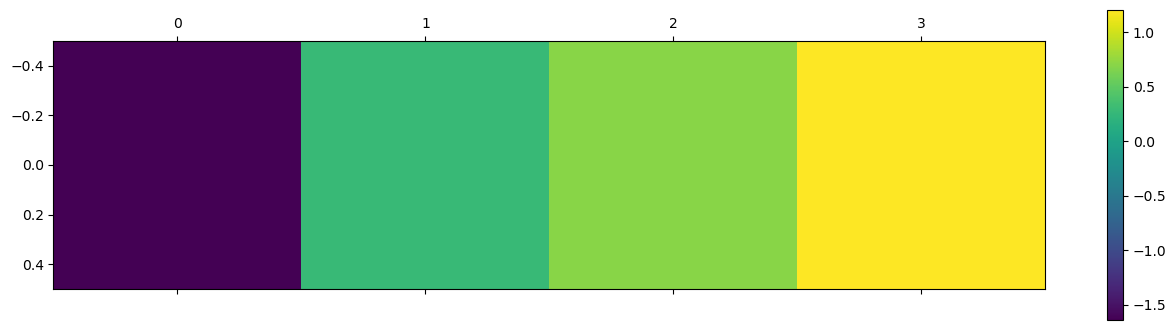

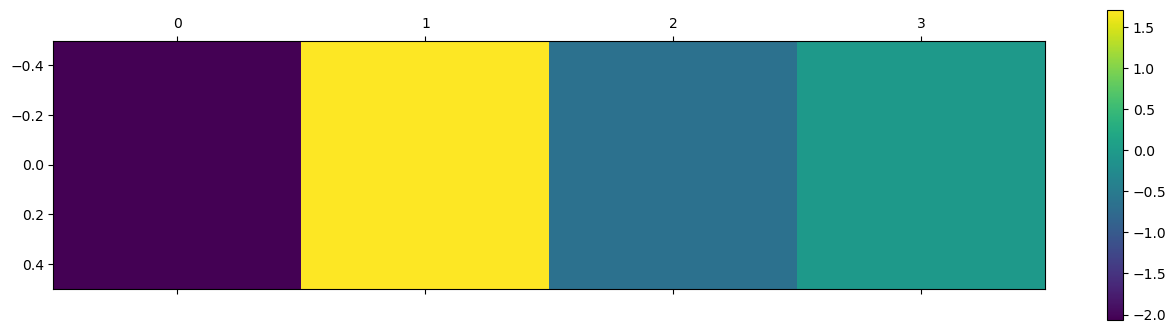

Linear(in_features=1, out_features=1, bias=True)


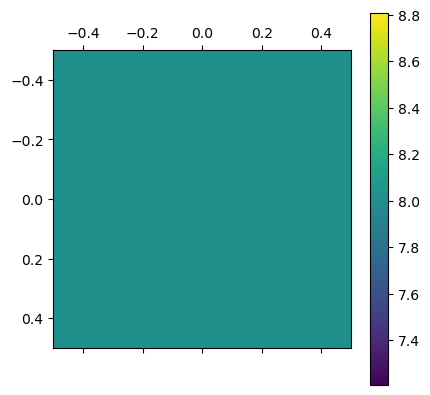

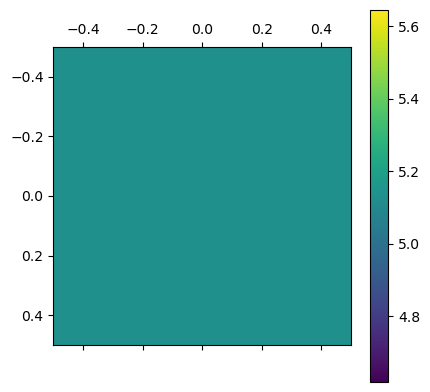

In [ ]:

with torch.no_grad():
    model.eval()
    first = True
    for m in model.modules():
        if first:
            first = False
            continue
        print(m)
        for p in m.parameters():
            p = p.cpu().numpy()
            plt.matshow(p.reshape(-1,p.shape[-1]),cmap = 'viridis')
            plt.colorbar()
            plt.show()
            plt.close()

# Adding skip connections

In [ ]:
class LSTMModelWithSkip(nn.Module):
    def __init__(self,input_dims=4,hidden_dims=64,num_output_neurons=1,num_layers = 1,bidirectionality = False):
        super().__init__()
        self.inp = input_dims
        self.num_layers = num_layers
        self.hid = hidden_dims
        self.out = num_output_neurons
        self.bidir = bidirectionality
        self.recording = True
        self.record={}
        D = 4 if self.bidir else 1
        self.RNN = nn.LSTM(self.inp,self.hid,self.num_layers,batch_first = True,bidirectional=self.bidir)

        self.DNN1 = nn.Linear(D*self.hid,D*self.hid)
        self.bn1 = nn.BatchNorm1d(D*self.hid)
        self.DNN2 = nn.Linear(2*D*self.hid,D*self.hid)
        self.bn2 = nn.BatchNorm1d(D*self.hid)
        self.DNN3 = nn.Linear(2*D*self.hid,D*self.hid)
        self.bn3 = nn.BatchNorm1d(D*self.hid)
        self.DNN4 = nn.Linear(2*D*self.hid,D*self.hid)
        self.bn4 = nn.BatchNorm1d(D*self.hid)
        self.DNN5 = nn.Linear(2*D*self.hid,D*self.hid)
        self.bn5 = nn.BatchNorm1d(D*self.hid)
        self.DNN6 = nn.Linear(2*D*self.hid,D*self.hid)
        self.bn6 = nn.BatchNorm1d(D*self.hid)
        self.DNN7 = nn.Linear(2*D*self.hid,D*self.hid)
        self.bn7 = nn.BatchNorm1d(D*self.hid)
        self.DNN8 = nn.Linear(2*D*self.hid,D*self.hid)
        self.bn8 = nn.BatchNorm1d(D*self.hid)
        self.DNN9 = nn.Linear(2*D*self.hid,self.out)
    def start_recording(self):
        self.recording = True
    def stop_recording(self):
        self.recording = False
    def forward(self,x):
        '''
        Note: x should be ending with a $ sign, the encoding of which is [0,0,0,0]. This will be passed to the DNN
        if is bidirectional, then should start and end with $ signs
        '''

        out,_ = self.RNN(x)
        # print(out,type(out))
        if not self.bidir:
            last_token = out[:,-1,:]
            out1 = F.dropout(F.relu(self.bn1(self.DNN1(last_token))),p=0.1)
            out2 = F.dropout(F.relu(self.bn2(self.DNN2(torch.concatenate((last_token,out1),dim=-1)))),p=0.1)
            out3 = F.dropout(F.relu(self.bn3(self.DNN3(torch.concatenate((out1,out2),dim=-1)))),p=0.1)
            out4 = F.dropout(F.relu(self.bn4(self.DNN4(torch.concatenate((out2,out3),dim=-1)))),p=0.1)
            out5 = F.dropout(F.relu(self.bn3(self.DNN5(torch.concatenate((out3,out4),dim=-1)))),p=0.1)
            out6 = F.dropout(F.relu(self.bn4(self.DNN6(torch.concatenate((out4,out5),dim=-1)))),p=0.1)
            out7 = F.dropout(F.relu(self.bn3(self.DNN7(torch.concatenate((out5,out6),dim=-1)))),p=0.1)
            out8 = F.dropout(F.relu(self.bn4(self.DNN8(torch.concatenate((out6,out7),dim=-1)))),p=0.1)
            out = self.DNN9(torch.concatenate((out7,out8),dim=-1))
            if self.recording:
                self.record = {'last_token':last_token,'out1':out1,'out2':out2,'out3':out3,'out4':out4,'out5':out5,'out6':out6,'out7':out7,'out8':out8,'out9':out}
        else:
            last_token = out[:,-1,:]
            first_token = out[:,0,:]
            out = F.dropout(F.relu(self.bn1(self.DNN1(torch.concatenate((first_token,last_token),dims=-1)))),p=0.1)
            out = F.dropout(F.relu(self.bn2(self.DNN2(out))),p=0.1)
            out = F.dropout(F.relu(self.bn3(self.DNN3(out))),p=0.1)
            out = (self.DNN4(out))
        out = F.sigmoid(out)
        out = torch.reshape(out,(-1,self.out))
        if self.recording:
            self.record['out'] = out
        return out

model = LSTMModelWithSkip()
print(model)


LSTMModelWithSkip(
  (RNN): LSTM(4, 64, batch_first=True)
  (DNN1): Linear(in_features=64, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (DNN2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (DNN3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (DNN4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (DNN5): Linear(in_features=128, out_features=64, bias=True)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (DNN6): Linear(in_features=128, out_features=64, bias=True)
  (bn6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (DNN7): Linear(in_features=128, out

In [ ]:

# Training the model
learning_rate = 0.02
epochs = 15
batch_size = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
model.to(float)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:

losses = []
testing_loss = []
accuracies = []
testing_accuracies = []
its=[]
count=0
for e in tqdm(range(epochs)):
    total_minibatches = len(train_data)//batch_size
    for i in range(total_minibatches):
        model.train()
        if i!=total_minibatches-1:
            input_data = train_data[i*batch_size:(i+1)*batch_size].to(device)
            y_true = train_target[i*batch_size:(i+1)*batch_size].to(device)
        else:
            input_data = train_data[i*batch_size:].to(device)
            y_true = train_target[i*batch_size:].to(device)
        y_pred = model(input_data)
        # print(y_pred,y_true)
        loss = criterion(y_pred,y_true)
        losses.append(loss.item())
        its.append(count)
        count+=1
        loss.backward()
        tel,tea = get_acc(test_data,test_target)
        tal,taa = get_acc(input_data,y_true)
        testing_loss.append(tel)
        accuracies.append(taa)
        testing_accuracies.append(tea)
        optimizer.step()
        optimizer.zero_grad()


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [04:28<00:00, 17.92s/it]


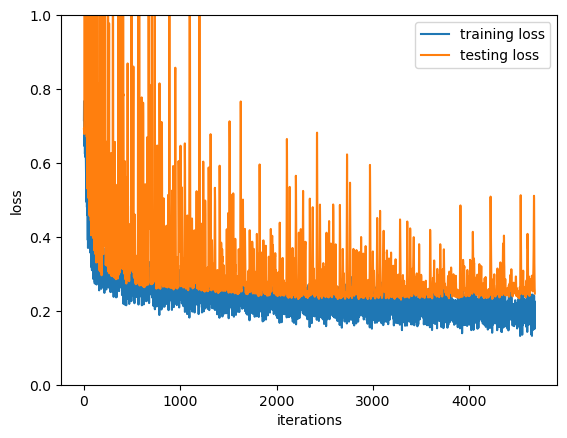

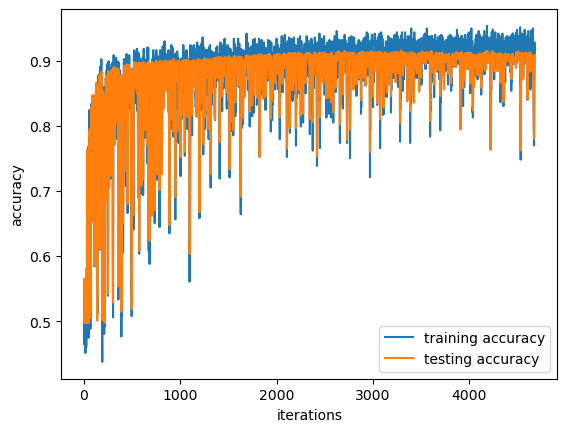

The final testing loss is 0.25 and the final testing accuracy is 0.91


In [ ]:
       
plt.plot(its,losses,label='training loss')
plt.plot(its,testing_loss,label='testing loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.ylim(0,1)
plt.legend()
plt.show()
plt.close()

plt.plot(its,accuracies,label='training accuracy')
plt.plot(its,testing_accuracies,label='testing accuracy')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.legend()
plt.show()
## Checking on a testing data to see how the model performs
l,a = get_acc(test_data,test_target)
print('The final testing loss is %.2f and the final testing accuracy is %.2f' % (l,a))
# torch.save(model,f'./models/model_LSTMModelWithSkip_{a}.pt')

{'last_token': tensor([[-1.8049e-02,  9.2799e-01, -1.6899e-02,  ...,  2.7838e-03,
         -2.6420e-01,  3.3097e-02],
        [-9.4560e-03,  8.7400e-01, -3.9554e-02,  ..., -1.3572e-03,
         -4.4669e-01,  1.5076e-02],
        [-6.6325e-03,  8.5168e-01, -6.0121e-03,  ...,  1.6632e-02,
         -5.0806e-01,  1.2452e-02],
        ...,
        [-3.1161e-03,  9.1442e-01, -1.7346e-02,  ...,  1.3926e-02,
         -3.4031e-01,  9.4502e-03],
        [-1.2485e-03,  8.8218e-01, -8.4438e-03,  ..., -1.6057e-05,
         -6.6730e-01,  4.2498e-03],
        [-5.6698e-02,  9.4495e-01, -2.7425e-02,  ..., -4.8987e-02,
         -2.6658e-01,  1.5822e-02]], device='cuda:0', dtype=torch.float64), 'out1': tensor([[0.0000, 1.3326, 0.7096,  ..., 0.0000, 1.0895, 0.0000],
        [0.0214, 1.2957, 0.9755,  ..., 0.0000, 0.0000, 0.0000],
        [1.0659, 0.0000, 0.0000,  ..., 1.1436, 2.0469, 0.0626],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.2761, 0.0000, 0.3020],
        [0.0000, 3.1946, 1.5379,  ...

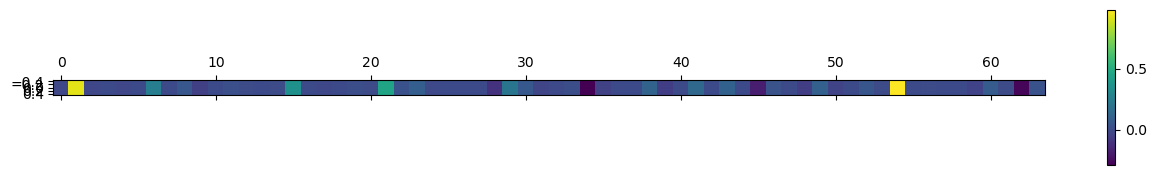

out1


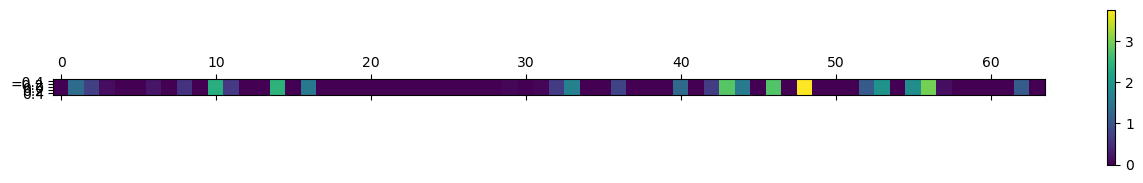

out2


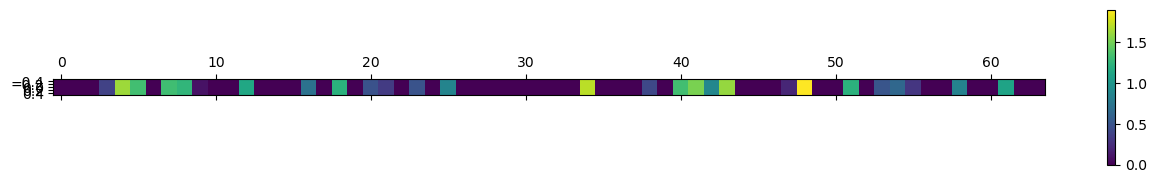

out3


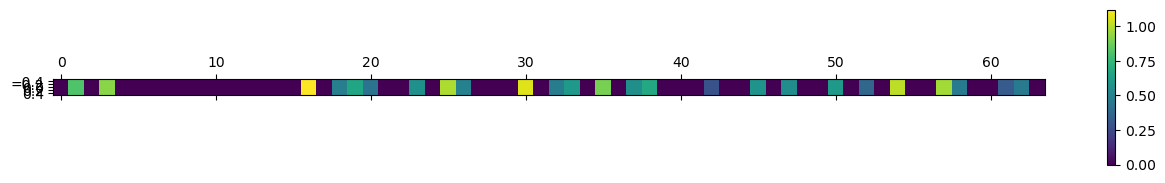

out4


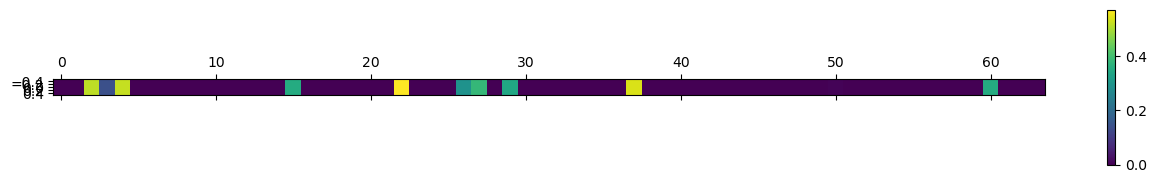

out5


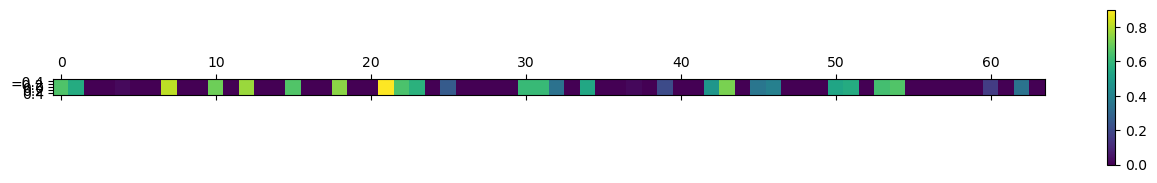

out6


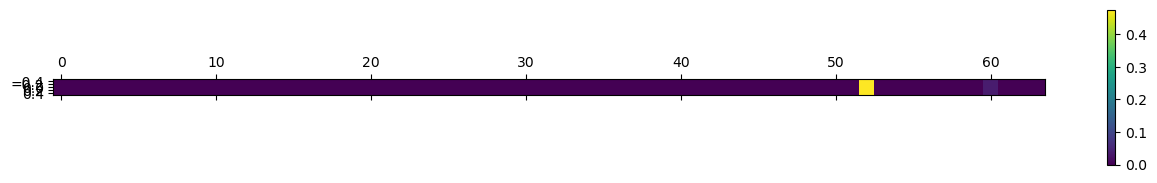

out7


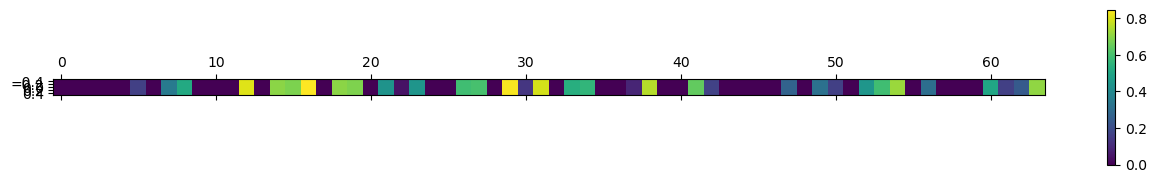

out8


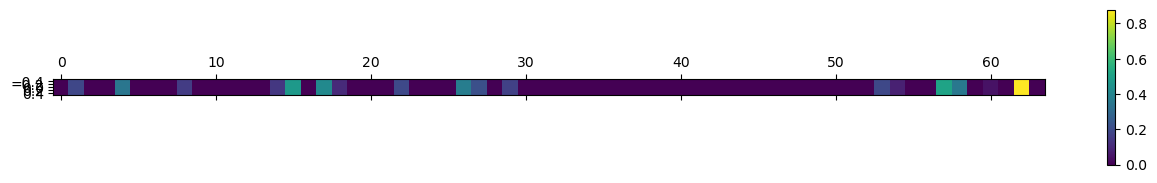

out9


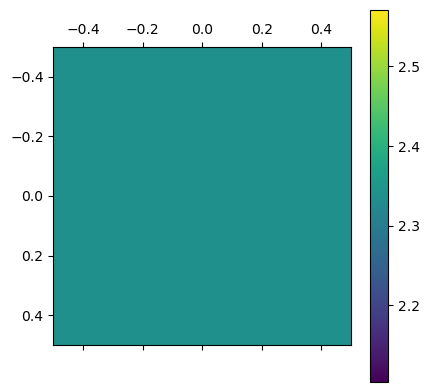

out


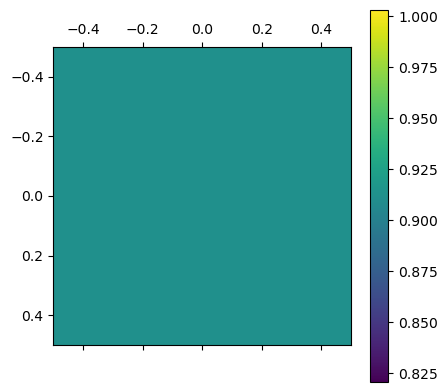

In [ ]:
print(model.record)
for k in model.record:
    print(k)
    plt.matshow(model.record[k].cpu().detach().numpy()[:1],cmap = 'viridis')
    plt.colorbar()
    plt.show()
    plt.close()

LSTM(4, 64, batch_first=True)


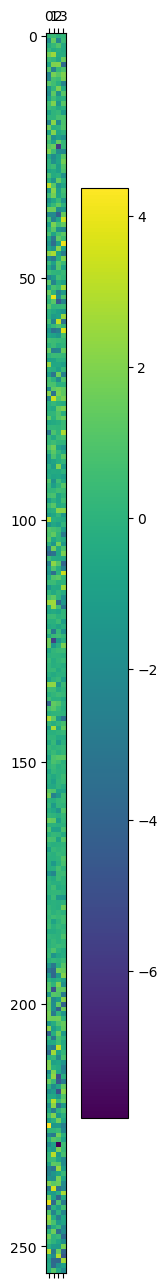

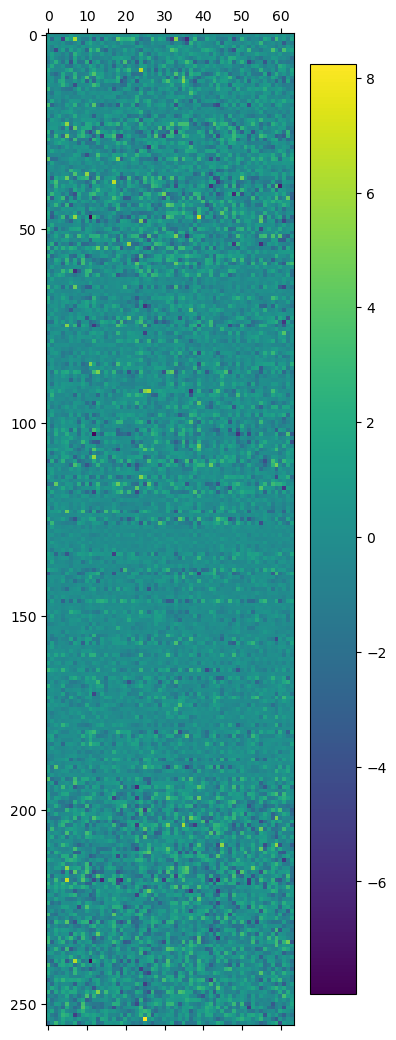

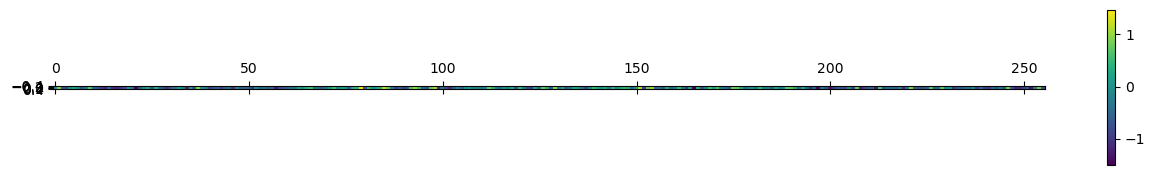

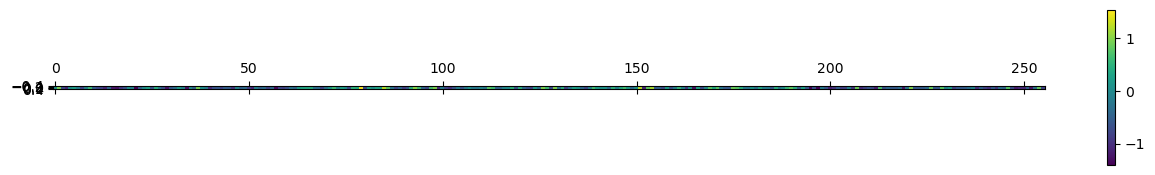

Linear(in_features=64, out_features=64, bias=True)


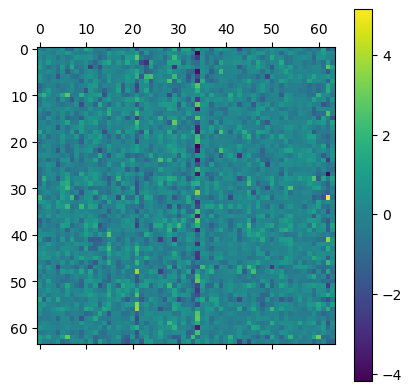

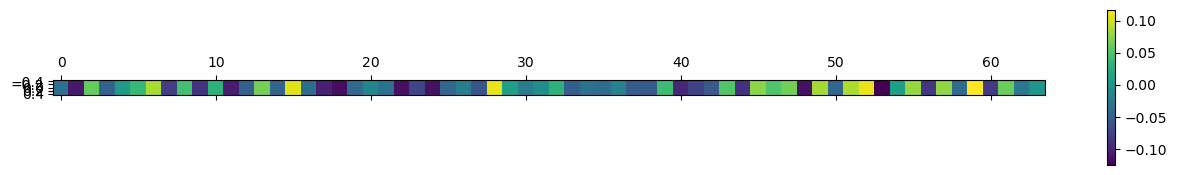

BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


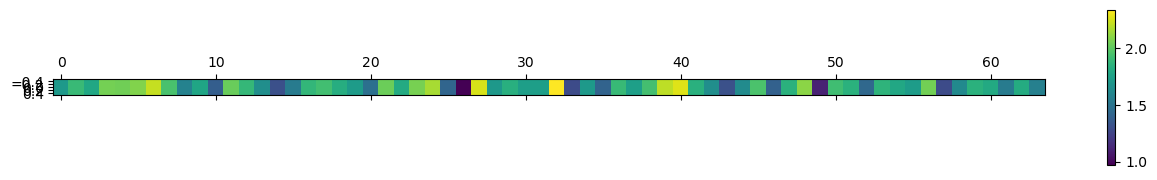

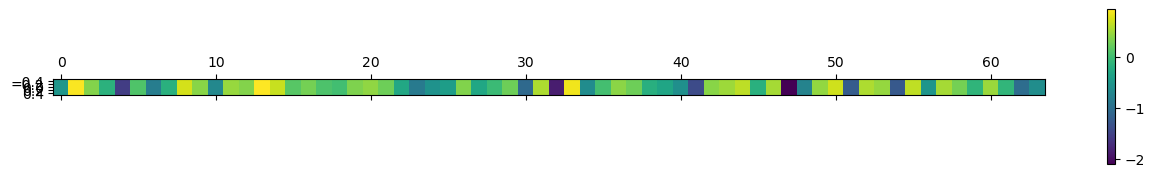

Linear(in_features=128, out_features=64, bias=True)


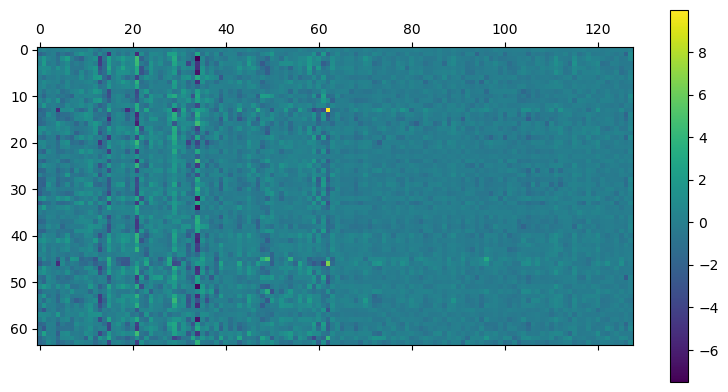

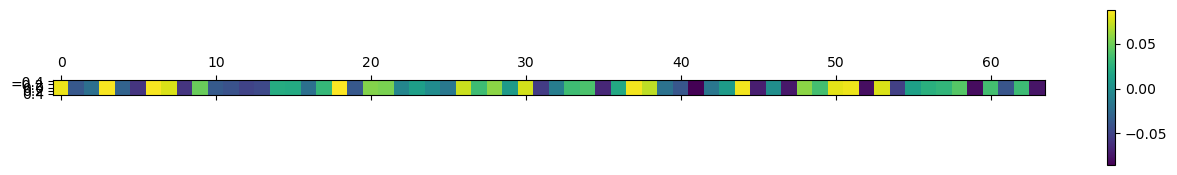

BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


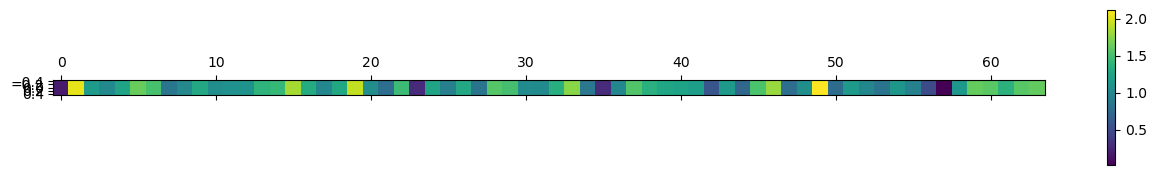

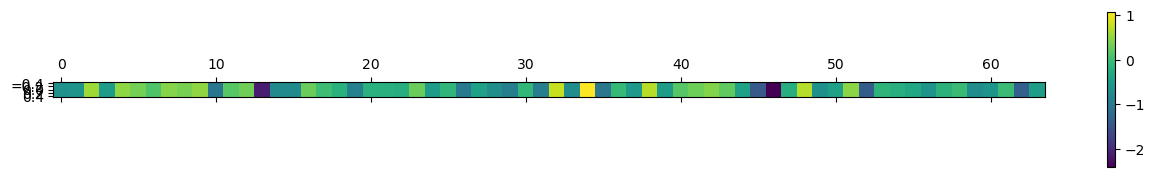

Linear(in_features=128, out_features=64, bias=True)


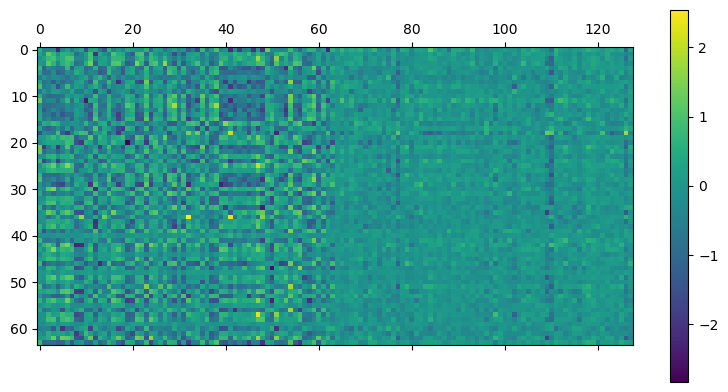

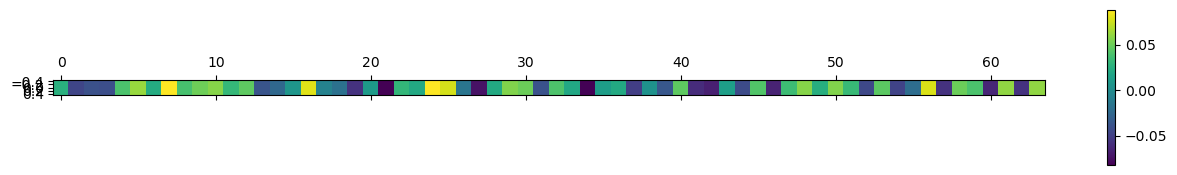

BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


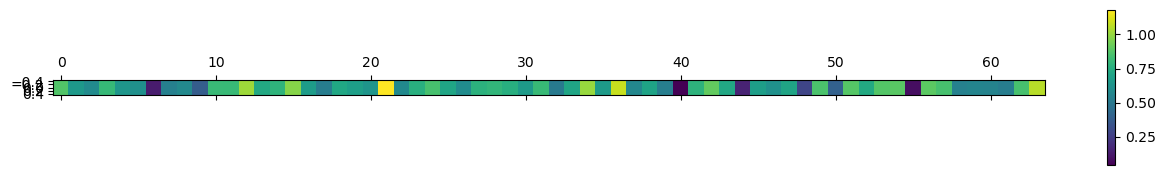

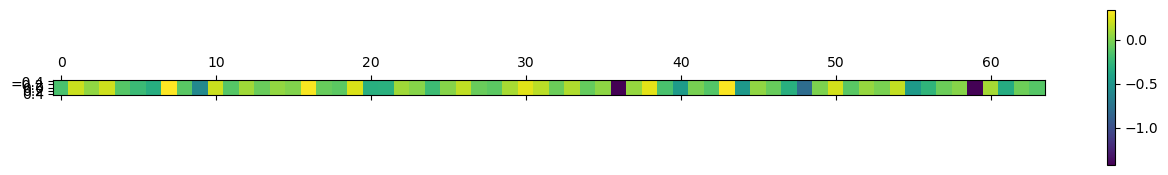

Linear(in_features=128, out_features=64, bias=True)


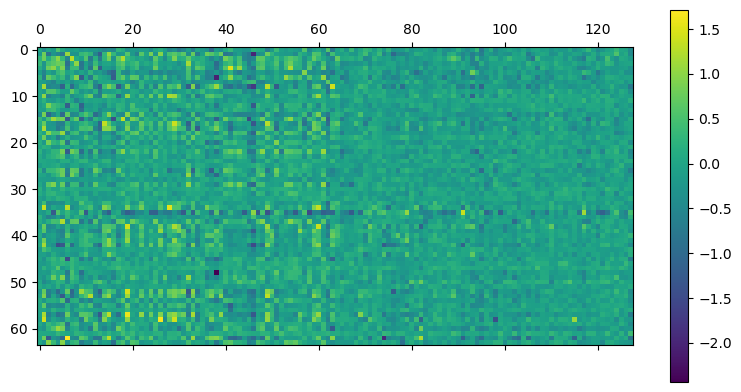

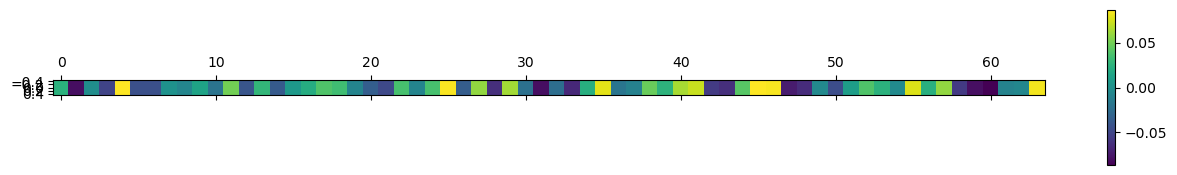

BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


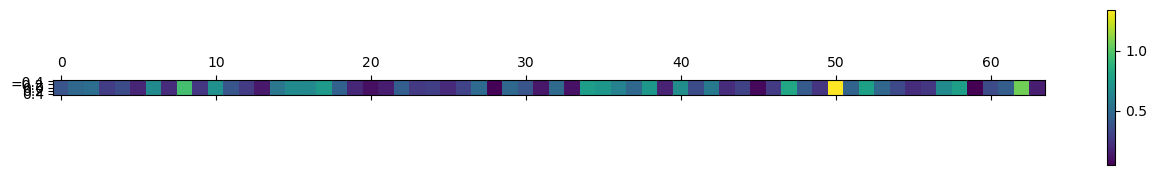

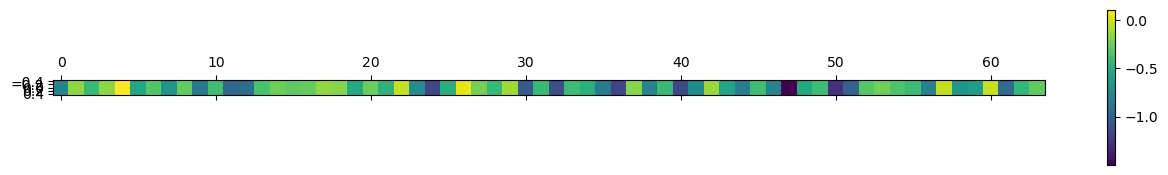

Linear(in_features=128, out_features=64, bias=True)


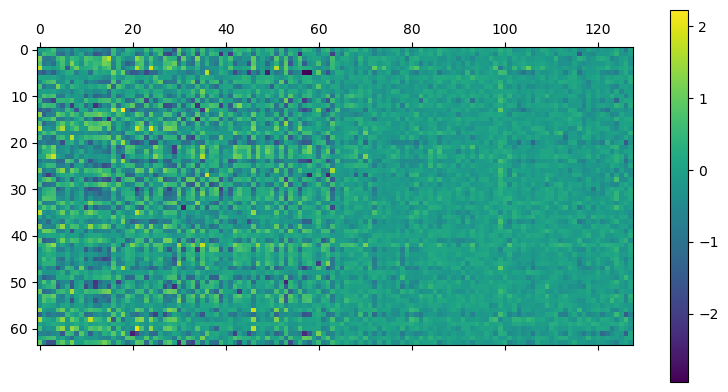

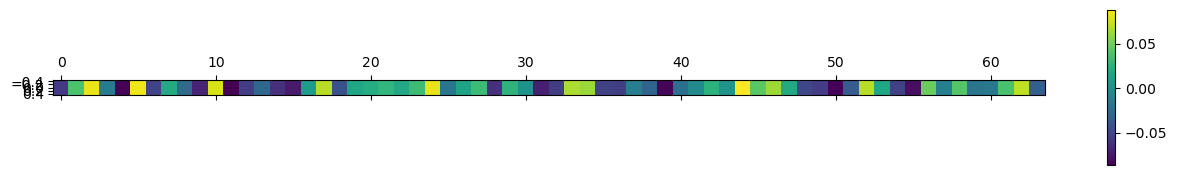

BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


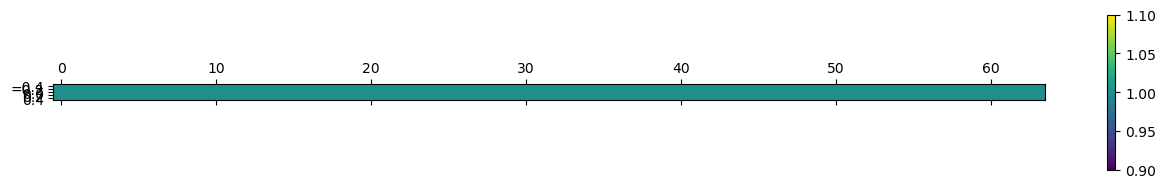

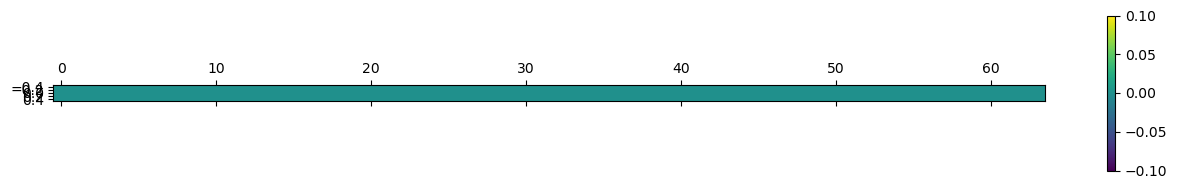

Linear(in_features=128, out_features=64, bias=True)


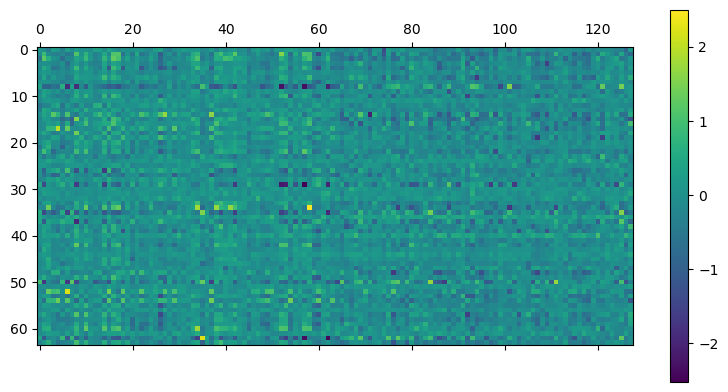

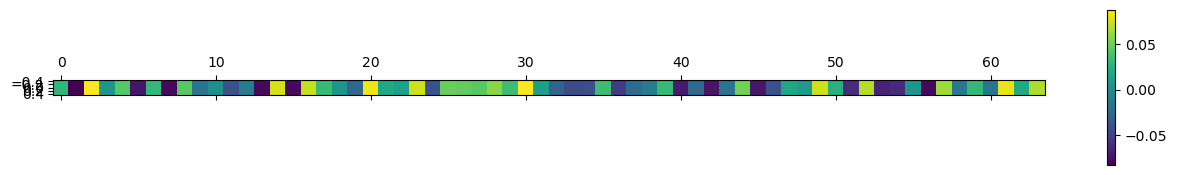

BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


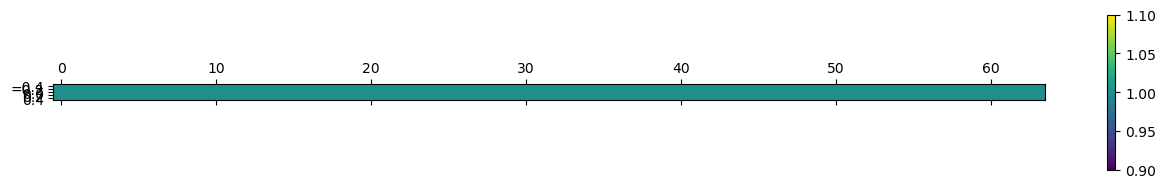

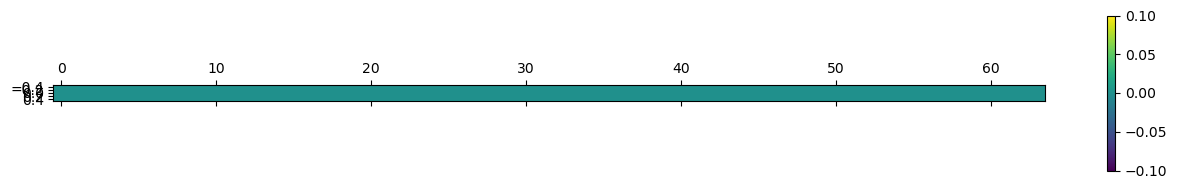

Linear(in_features=128, out_features=64, bias=True)


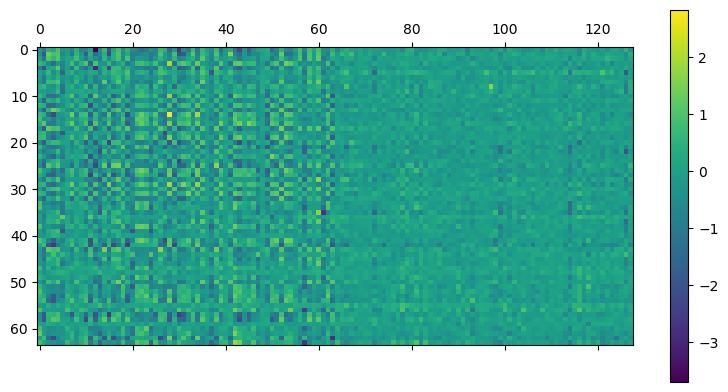

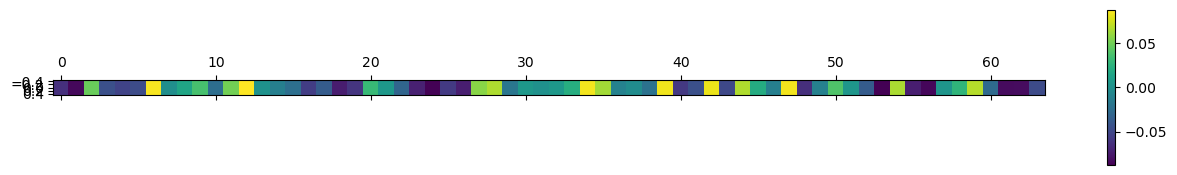

BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


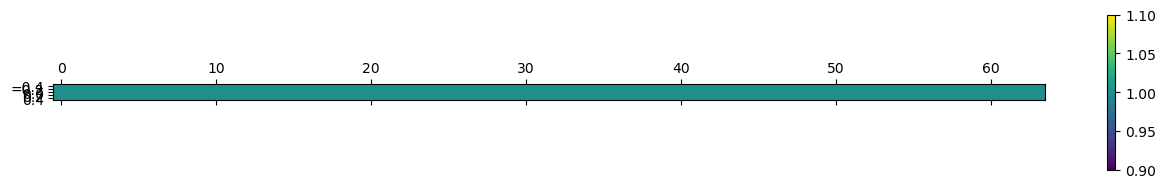

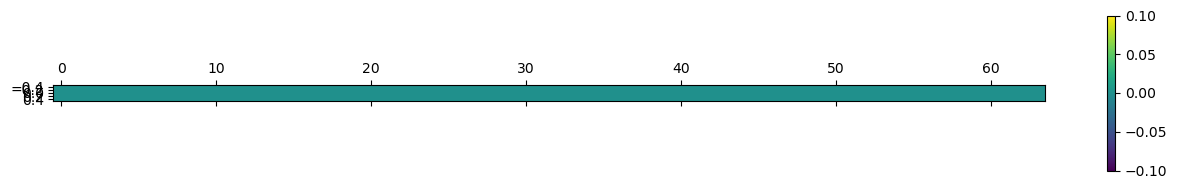

Linear(in_features=128, out_features=64, bias=True)


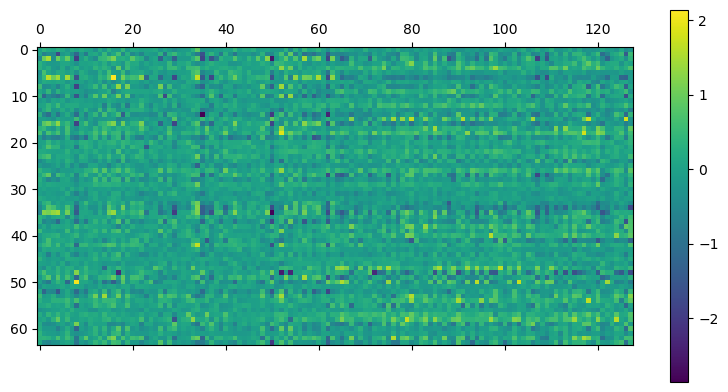

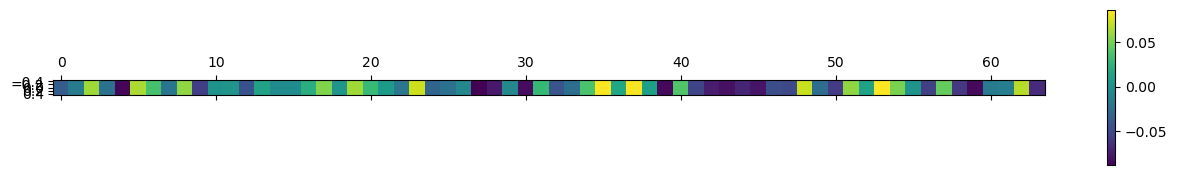

BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


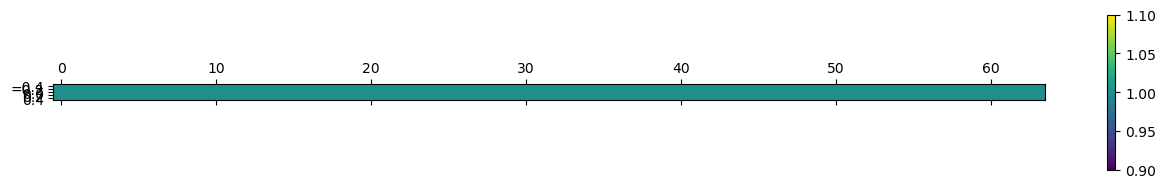

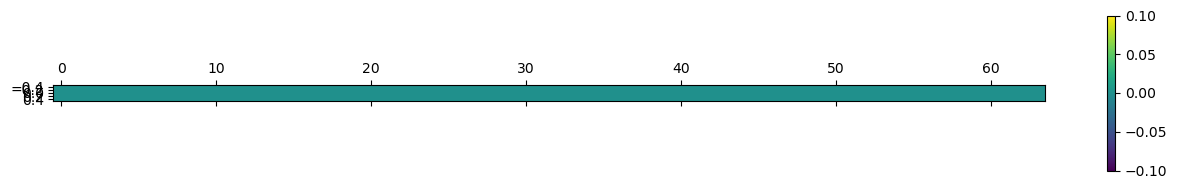

Linear(in_features=128, out_features=1, bias=True)


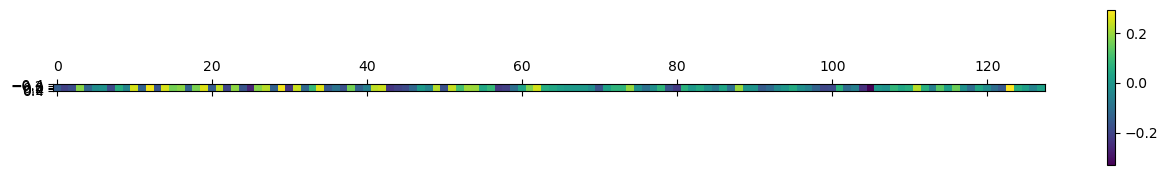

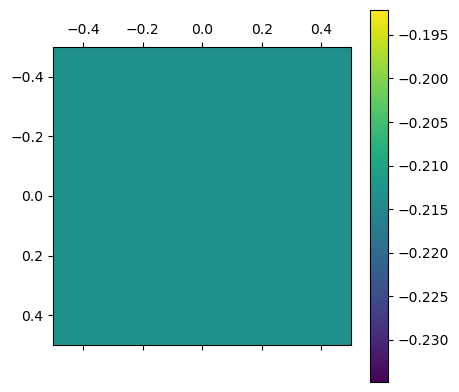

In [ ]:
layer_no = 0
with torch.no_grad():
    model.eval()
    first = True
    for m in model.modules():
        if first:
            first = False
            continue
        print(m)
        for p in m.parameters():
            p = p.cpu().numpy()
            plt.matshow(p.reshape(-1,p.shape[-1]),cmap = 'viridis')
            plt.colorbar()
            plt.show()
            plt.close()


# Adjusting the data for a CNN

In [ ]:
print('Original training data shape :',train_data.shape)
train_data_CNN = torch.permute(train_data,(0,2,1))
print('New training data shape : ',train_data_CNN.shape)

train_target_CNN = train_target.to(float) # For consistency

print('Original testing data shape :',test_data.shape)
test_data_CNN = torch.permute(test_data,(0,2,1))
print('New testing data shape : ',test_data_CNN.shape)
test_target_CNN = test_target.to(float)


Original training data shape : torch.Size([159784, 82, 4])
New training data shape :  torch.Size([159784, 4, 82])
Original testing data shape : torch.Size([39947, 82, 4])
New testing data shape :  torch.Size([39947, 4, 82])


# Making the CNN

In [ ]:

class PyramidalCNN(nn.Module):
    def __init__(self,num_heads=1,output_size=4,kernel_size=2):
        super().__init__()
        '''
        Takes a batch or an unbatched input and assimilated information from the surrounding bases, until only one vector remians
        input shape = (N,1,82) 80 LENGTH OF SEQUENCE + 1 START CODE +1 END CODE
        '''
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.cnn_list = []
        for i in range(81):
            if i==0:
                self.cnn_list.append(nn.Conv1d(4,num_heads,kernel_size=kernel_size,padding=0))
            elif i==80:
                self.cnn_list.append(nn.Conv1d(num_heads,output_size,kernel_size=kernel_size,padding=0))
            else:
                self.cnn_list.append(nn.Conv1d(num_heads,num_heads,kernel_size=kernel_size,padding=0))
        for i,c in enumerate(self.cnn_list):
            self.add_module(name=str(c)[:6]+'_'+str(i),module=c)
    def forward(self,x):
        # the shape of x must be N,1,82
        for c in self.cnn_list:
            x = F.relu(c(F.pad(x,(self.kernel_size-2,0))))
        return torch.reshape(x,(-1,self.output_size))
class PyramidalClassifier(nn.Module):
    def __init__(self,num_heads,output_size,kernel_size):
        super().__init__()
        self.PyCNN = PyramidalCNN(num_heads=num_heads,output_size=output_size,kernel_size=kernel_size)
        self.DNN = nn.Linear(output_size,1)
    def forward(self,x):
        x = self.PyCNN(x)
        x = F.sigmoid(self.DNN(x))
        return x

model = PyramidalClassifier(num_heads=10,output_size=4,kernel_size=10)
print(model)

# Uncommenting this will show how the output is shaped

# trial_x = torch.rand(1000,4,82)
# print(trial_x.shape)
# model(trial_x).shape

PyramidalClassifier(
  (PyCNN): PyramidalCNN(
    (Conv1d_0): Conv1d(4, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_1): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_2): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_3): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_4): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_5): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_6): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_7): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_8): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_9): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_10): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_11): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_12): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_13): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (Conv1d_14): Conv1d(10, 10, kernel_size=(10,), stride=(1,))
    (

## Training the model

In [ ]:
learning_rate = 0.001
epochs = 20
batch_size = 2048
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
model.to(float)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


In [ ]:

# losses = []
# testing_loss = []
# accuracies = []
# testing_accuracies = []
# its=[]
# count=0
# for e in tqdm(range(epochs)):
#     total_minibatches = len(train_data_CNN)//batch_size
#     for i in range(total_minibatches):
#         model.train()
#         if i!=total_minibatches-1:
#             input_data = train_data_CNN[i*batch_size:(i+1)*batch_size].to(device)
#             y_true = train_target_CNN[i*batch_size:(i+1)*batch_size].to(device)
#         else:
#             input_data = train_data_CNN[i*batch_size:].to(device)
#             y_true = train_target_CNN[i*batch_size:].to(device)
#         y_pred = model(input_data)
#         # print(y_pred,y_true)
#         loss = criterion(y_pred,y_true)
#         losses.append(loss.item())
#         its.append(count)
#         count+=1
#         loss.backward()
#         tel,tea = get_acc(test_data_CNN,test_target_CNN)
#         tal,taa = get_acc(input_data,y_true)
#         testing_loss.append(tel)
#         accuracies.append(taa)
#         testing_accuracies.append(tea)
#         optimizer.step()
#         optimizer.zero_grad()


 66%|██████▌   | 33/50 [47:44<24:35, 86.81s/it] 


KeyboardInterrupt: 

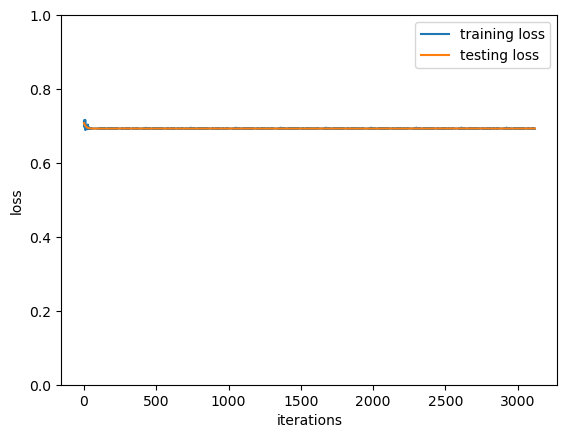

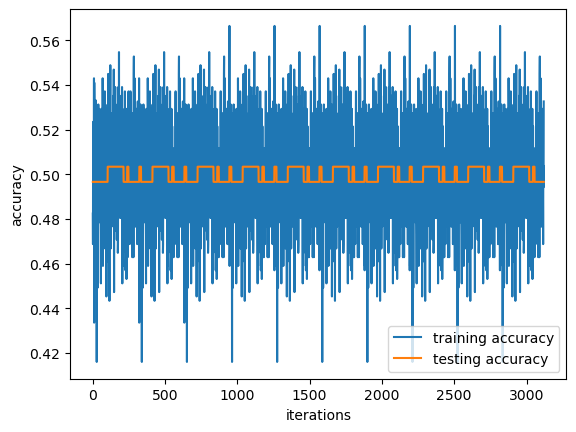

The final testing loss is 0.69 and the final testing accuracy is 0.50


In [ ]:
# plt.plot(its,losses,label='training loss')
# plt.plot(its,testing_loss,label='testing loss')
# plt.xlabel('iterations')
# plt.ylabel('loss')
# plt.ylim(0,1)
# plt.legend()
# plt.show()
# plt.close()

# plt.plot(its,accuracies,label='training accuracy')
# plt.plot(its,testing_accuracies,label='testing accuracy')
# plt.xlabel('iterations')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show()
# ## Checking on a testing data to see how the model performs
# # print('The final testing loss is %.2f and the final testing accuracy is %.2f' % ())
# l,a = get_acc(test_data_CNN,test_target_CNN)
# print('The final testing loss is %.2f and the final testing accuracy is %.2f' % (l,a))
# torch.save(model,f'./models/model_PyramidalClassifier_{a}.pt')

In [ ]:
end_time = time.time()
print('Time taken to execute = ', end_time-start_time)

Time taken to execute =  57942.35547995567


# A different CNN

In [43]:

class CNNBreathing(nn.Module):
    def __init__(self,num_heads=1,output_size=4,kernel_size=2,total=5):
        super().__init__()
        '''
        Takes a batch or an unbatched input and assimilated information from the surrounding bases, until only one vector remians
        input shape = (N,1,82) 80 LENGTH OF SEQUENCE + 1 START CODE +1 END CODE
        '''
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.cnn_list = []
        for i in range(total):
            if i==0:
                self.cnn_list.append(nn.Conv1d(4,num_heads,kernel_size=kernel_size))
            elif i==total-1:
                self.cnn_list.append(nn.ConvTranspose1d(num_heads,num_heads,kernel_size=kernel_size))
                self.cnn_list.append(nn.Conv1d(num_heads,output_size,kernel_size=kernel_size))
                self.cnn_list.append(nn.ConvTranspose1d(output_size,output_size,kernel_size=kernel_size))
            else:
                self.cnn_list.append(nn.ConvTranspose1d(num_heads,num_heads,kernel_size=kernel_size))
                self.cnn_list.append(nn.Conv1d(num_heads,num_heads,kernel_size=kernel_size))
        for i,c in enumerate(self.cnn_list):
            self.add_module(name=str(c)[:6]+'_'+str(i),module=c)
    def forward(self,x):
        # the shape of x must be N,1,82
        for c in self.cnn_list:
            # print(c)
            x = F.relu(c(x))
        #     print(x.shape)
        # print(x.shape)
        return torch.reshape(x,(-1,self.output_size))
class NormalCNNClassifier(nn.Module):
    def __init__(self,num_heads=4,output_size=4,kernel_size=2,total=4):
        super().__init__()
        self.output_size = output_size
        self.PyCNN = CNNBreathing(num_heads=num_heads,output_size=output_size,kernel_size=kernel_size,total=total)
        self.DNN = nn.Sequential(nn.Linear(output_size*82,512),nn.BatchNorm1d(512),nn.ReLU(),nn.Dropout(p=0.1),nn.Linear(512,1))
        
        # self.DNN = nn.Sequential(nn.Linear(output_size*82,512),nn.BatchNorm1d(512),nn.ReLU(),nn.Dropout(p=0.1),nn.Linear(512,512),nn.BatchNorm1d(512),nn.ReLU(),nn.Dropout(p=0.1),nn.Linear(512,512),nn.BatchNorm1d(512),nn.ReLU(),nn.Dropout(p=0.1),nn.Linear(512,1))
    
    def forward(self,x):
        x = self.PyCNN(x)
        x = F.sigmoid(self.DNN(torch.reshape(x,(-1,self.output_size*(82)))))
        return x

model = NormalCNNClassifier(num_heads=32,kernel_size=5,total=4)
print(model)
# model = PyramidalClassifier(num_heads=10,output_size=4,kernel_size=10)
# print(model)


NormalCNNClassifier(
  (PyCNN): CNNBreathing(
    (Conv1d_0): Conv1d(4, 32, kernel_size=(5,), stride=(1,))
    (ConvTr_1): ConvTranspose1d(32, 32, kernel_size=(5,), stride=(1,))
    (Conv1d_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (ConvTr_3): ConvTranspose1d(32, 32, kernel_size=(5,), stride=(1,))
    (Conv1d_4): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (ConvTr_5): ConvTranspose1d(32, 32, kernel_size=(5,), stride=(1,))
    (Conv1d_6): Conv1d(32, 4, kernel_size=(5,), stride=(1,))
    (ConvTr_7): ConvTranspose1d(4, 4, kernel_size=(5,), stride=(1,))
  )
  (DNN): Sequential(
    (0): Linear(in_features=328, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [44]:

learning_rate = 0.001
epochs = 30
batch_size = 4096
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
model.to(float)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


In [45]:


losses = []
testing_loss = []
accuracies = []
testing_accuracies = []
its=[]
count=0
for e in tqdm(range(epochs)):
    total_minibatches = len(train_data_CNN)//batch_size
    for i in range(total_minibatches):
        model.train()
        if i!=total_minibatches-1:
            input_data = train_data_CNN[i*batch_size:(i+1)*batch_size].to(device)
            y_true = train_target_CNN[i*batch_size:(i+1)*batch_size].to(device)
        else:
            input_data = train_data_CNN[i*batch_size:].to(device)
            y_true = train_target_CNN[i*batch_size:].to(device)
        y_pred = model(input_data)
        # print(y_pred,y_true)
        loss = criterion(y_pred,y_true)
        losses.append(loss.item())
        its.append(count)
        count+=1
        loss.backward()
        tel,tea = get_acc(test_data_CNN,test_target_CNN)
        tal,taa = get_acc(input_data,y_true)
        testing_loss.append(tel)
        accuracies.append(taa)
        testing_accuracies.append(tea)
        optimizer.step()
        optimizer.zero_grad()


100%|██████████| 30/30 [08:29<00:00, 16.98s/it]


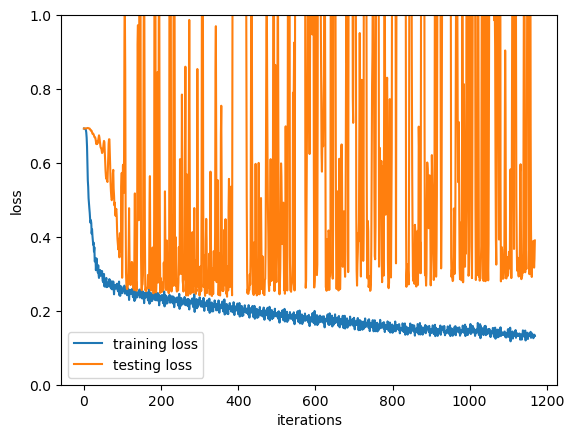

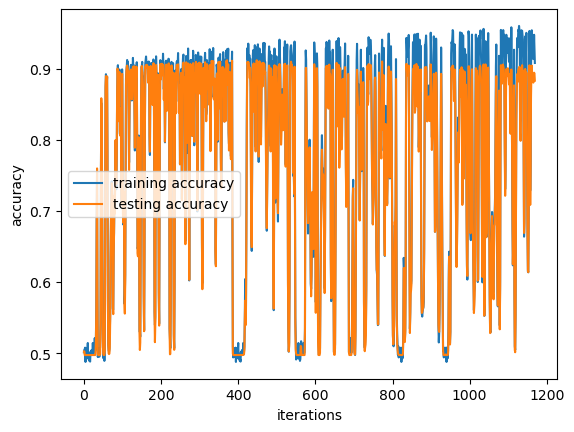

The final testing loss is 0.47 and the final testing accuracy is 0.86


In [46]:

plt.plot(its,losses,label='training loss')
plt.plot(its,testing_loss,label='testing loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.ylim(0,1)
plt.legend()
plt.show()
plt.close()

plt.plot(its,accuracies,label='training accuracy')
plt.plot(its,testing_accuracies,label='testing accuracy')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.legend()
plt.show()
## Checking on a testing data to see how the model performs
l,a = get_acc(test_data_CNN,test_target_CNN)
print('The final testing loss is %.2f and the final testing accuracy is %.2f' % (l,a))
torch.save(model,f'./models/model_NormalCNNClassifier_{a}.pt')